In [38]:
import numpy as np
from numpy.random import dirichlet
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [315]:
# an example test of the function
dirichlet(np.array([4, 4, 4]))

array([0.16762907, 0.42356285, 0.40880808])

In [32]:
# read in data from the spreadsheet Nick created
df = pd.read_csv("./amp_cnts-amp_cnts_NG-1.csv", header=None).T
df.columns = df.iloc[0]
df = df[1:]
df = df.loc[:,~df.columns.duplicated()]
df.drop(df.tail(1).index,inplace=True)

In [33]:
# normalise all columns so that they sum to 1
for c in df.columns:
    if not c in ["RAW COUNTS", "total admissible contributing", "Total"]:
        df[c] = df[c]/sum(df[c])

In [317]:
df.head()

,RAW COUNTS,Sample_A0_highconc_rep1,Sample_A0_highconc_rep2,Sample_A0_lowconc_rep1,Sample_A0_lowconc_rep2,Sample_A100_highconc_rep1,Sample_A100_highconc_rep2,Sample_A100_lowconc_rep1,Sample_A100_lowconc_rep2,Sample_A10_highconc_rep1,...,Sample_Ldn_110121_rep2,Sample_Ldn_120121_rep1,Sample_Ldn_120121_rep2,Sample_Ldn_130121_rep1,Sample_Ldn_130121_rep2,Sample_Ldn_140121_rep1,Sample_Ldn_140121_rep2,Total,total admissible contributing,proportion
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01029,0.0,0.050524,0.009291,0.0,0.0,0.006172,6513.0,801879.0,0.007534
2,2.0,0.006136,0.010507,0.0,0.0,0.008258,0.011527,0.0,0.0,0.020567,...,0.065587,0.002515,0.0,0.036219,0.020997,0.03305,0.014123,110944.0,3718115.0,0.027676
3,3.0,0.023466,0.033429,0.0,0.0,0.014088,0.0,0.0,0.0,0.02796,...,0.032464,0.0,0.088656,0.028979,0.021116,0.010386,0.041393,118560.0,3644980.0,0.03017
4,4.0,0.018408,0.012877,0.0,0.084564,0.025493,0.01032,0.172789,0.0,0.026286,...,0.010423,0.02289,0.0,0.0,0.001789,0.009367,0.011578,73092.0,3718115.0,0.018234
5,5.0,0.000547,0.00118,0.0,0.010738,0.000591,0.0,0.0,0.0,0.003127,...,0.000456,0.0,0.000953,0.000214,0.000517,0.002087,0.001046,6633.0,3644980.0,0.001688


In [244]:
# estimate is maybe a bad name - probably more appropriate is hyperparameter or alpha_vector
estimate = np.array(df["proportion"]).astype(float)
data_cols = [c for c in df.columns if c[:6] == "Sample"]
high_conc = [c for c in data_cols if c.split("_")[2] == "highconc"]

Sample_A0_highconc_rep1


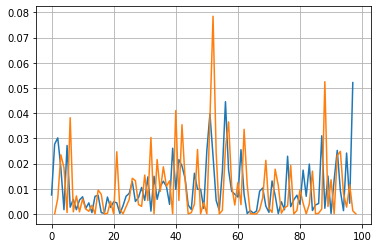

In [313]:
plt.plot(estimate)
n = 0
logging.info(data_cols[n])
plt.plot(df[data_cols[n]])
plt.grid()
# blue shows the vector 'proportion' in the spreadsheet - here it's called estimate
# orange is the first sample amplicon proportions. 

In [199]:
distributions = np.array(df[data_cols])

In [200]:
np.shape(distributions)

(98, 55)

In [207]:
distances = (distributions - np.multiply(estimate.reshape(98, 1), np.ones((1, 55)))) ** 2
distances = distances.mean(axis=1).astype(float)

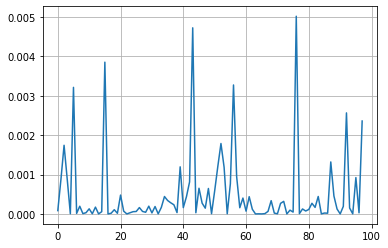

In [316]:
plt.plot(distances)
plt.grid()
# for each amplicon calculate the RMS deviation from the 'estimate' vector

Note about Dirichlet distribution (from Wikipedia). 

$$Var(p_i) = \frac{\tilde{\alpha_i} (1 - \tilde{\alpha_i})}{\alpha_0 + 1}$$

where $\alpha_0 = \Sigma_i \alpha_i$ and $\tilde{\alpha_i} = \alpha_i/\alpha_0$. 

The 'distances' that I've calculated are 

$$ d_i = (1/N) \times \Sigma_{j=1}^N (p_{ij} - \alpha_i)^2 $$ - i.e. exactly the variances for each amplicon (indexed by j) across all of the samples. 

So to try to match these two things up... 

$$\alpha_0 = \tilde{\alpha_i} (1 - \tilde{\alpha_i})/ d_i - 1$$

$\alpha_0$ (name taken from wikipedia) is the same as what we've called $c$ elsewhere. 

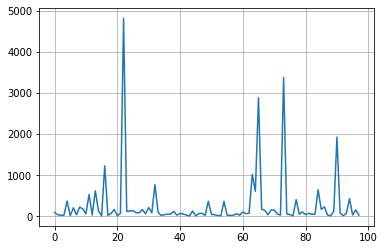

In [312]:
a_0_estimates = (estimate * (1 - estimate) / distances) - 1
plt.plot(a_0_estimates)
plt.grid()
# A few amplicons (21 for example) require an extremely large value of c, but most do not. 
# I think this is an amplicon that generally doesn't do well (often drops out). 

In [222]:
# these values below are intended to exclude some of the larger peaks seen above, and produce a value of c from
# the remaining amplicons. 
logging.info(np.mean([x for x in a_0_estimates if x < 100]))
logging.info(np.mean([x for x in a_0_estimates if x < 200]))
logging.info(np.mean([x for x in a_0_estimates if x < 300]))
logging.info(np.mean([x for x in a_0_estimates if x < 400]))
logging.info(np.mean([x for x in a_0_estimates if x < 500]))
logging.info(np.mean([x for x in a_0_estimates if x < 1000]))
logging.info(np.mean([x for x in a_0_estimates if x < 5000]))

37.6904471246965
60.09557604002756
65.74108836884261
79.84055186720529
83.76063810375567
113.27735418445576
261.5612122193286


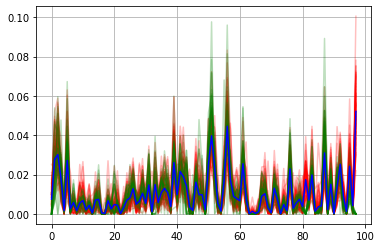

In [258]:
c = 261.0
for i in range(55):
    plt.plot(dirichlet(estimate * c), color="r", alpha=0.25)

distributions2 = np.array(df[high_conc])
plt.plot(distributions2, color="g", alpha=0.25)
plt.plot(estimate, color="b")
plt.grid()
# blue is the hyperparameter 'estiamte'
# green and the highconc values 
# red are sampled from the dirichlet with c = 261

In my opinion, to get roughly the right amount of variation for the highconc samples, you should use a c value of about 260 whereas to get roughly the right amount of variation for the highconc and lowconc samples combined (probably not recommended) you should use a value of c more like 10. 

Other way of doing a similar / analogous computation is what Nick suggested - will try this below:

In [309]:
distances_samples = (distributions - np.multiply(estimate.reshape(98, 1), np.ones((1, 55))))** 2
distances_samples = distances_samples.mean(axis=0).astype(float)

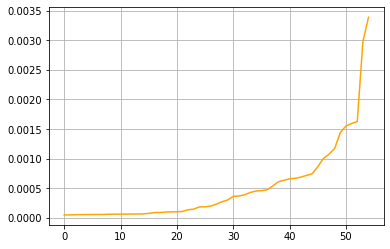

In [311]:
distances_samples.sort()
plt.plot(distances_samples, color="orange")
plt.grid()

In [286]:
c_data = []
for c in np.linspace(1, 300, 1000):
    ds = (dirichlet(c * estimate, 100).T - np.multiply(estimate.reshape(98, 1), np.ones((1, 100))))** 2
    c_data.append(ds.mean().astype(float))

In [287]:
ds.shape

(98, 100)

In [288]:
estimate.shape

(98,)

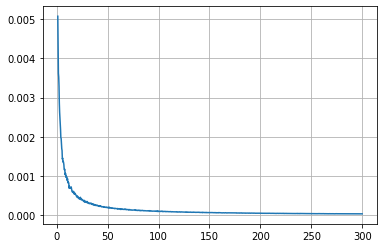

In [296]:
plt.plot(np.linspace(1, 300, 1000), c_data)
plt.grid()

I think this gives pretty similar results which is reassuring - most of the really large values in the orange plot above come from samples that just aren't at all well modelled by the dirichlet estimate, whereas for the 'highconc' samples (mainly the points closer to the origin) the var/$l_2$ distance is in the range 0.0001 or less, and the corresponding value for c is something like in the 100-200 range. 

In [320]:
# Note: the above analysis looks at rms distances, whereas a different analysis Nick did, looking at
# certain amplicons which often were sampled with 0 samples (e.g. amplicon 21) is a sort of worst-case
# analysis. That produced an answer for c as more like 10,000. 

estimate

array([0.00753351, 0.02767619, 0.03016951, 0.0182336 , 0.00168787,
       0.02715856, 0.00266986, 0.00577876, 0.00167795, 0.00552556,
       0.00680799, 0.00214661, 0.00437453, 0.00050466, 0.00699502,
       0.00738928, 0.0005182 , 0.00021404, 0.00668992, 0.00260138,
       0.00480127, 0.00441845, 0.00020841, 0.00317913, 0.00700367,
       0.00813043, 0.01281263, 0.00494905, 0.00651281, 0.0105058 ,
       0.00538476, 0.01468027, 0.00110117, 0.01495693, 0.0057802 ,
       0.01089645, 0.01300068, 0.01087575, 0.00378315, 0.02606841,
       0.00974758, 0.02153571, 0.01898343, 0.01411075, 0.00352894,
       0.00175645, 0.01614715, 0.00974344, 0.00978346, 0.00217689,
       0.02508223, 0.03970569, 0.02292791, 0.00537039, 0.00141509,
       0.01691794, 0.04453032, 0.01739715, 0.00897833, 0.00781037,
       0.00671129, 0.0254974 , 0.00774748, 0.00015117, 0.0013406 ,
       0.00026141, 0.00118021, 0.0090235 , 0.01027942, 0.00308284,
       0.00062039, 0.01306926, 0.00732532, 0.0001165 , 0.00482

In [338]:
# uncomment this to create the hyperparameter file 
#with open("amplicon_prior.csv", "w") as f:
#    f.write("amplicon_number,hyperparameter\n")
#    for i, e in enumerate(estimate):
#        f.write(f"{i+1},{e}\n")